<img src='../__docs/__all/notebook_rules.png' />

# Python Import 

In [1]:
debugging = True

import os

import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import glob
# from NeuNorm.normalization import Normalization
import numpy as np

from ipywidgets import interactive
import ipywidgets as widgets

import matplotlib.pyplot as plt
%matplotlib notebook

from plotly.offline import plot, init_notebook_mode, iplot
import plotly.express as px
import plotly.graph_objects as go

# from __code.file_folder_browser import FileFolderBrowser

from __code import system
system.System.select_working_dir()

from code.ipts_28402 import IPTS_28402


** Using Debugging Mode! **


# Select Images 

In [2]:
o_ipts = IPTS_28402(working_dir=system.System.get_working_dir(), debugging=debugging)
o_ipts.select_images()

# Visualize Raw Data

The data are rotated 90 degrees to work with the cylindrical geometry algorithm

<IPython.core.display.Javascript object>


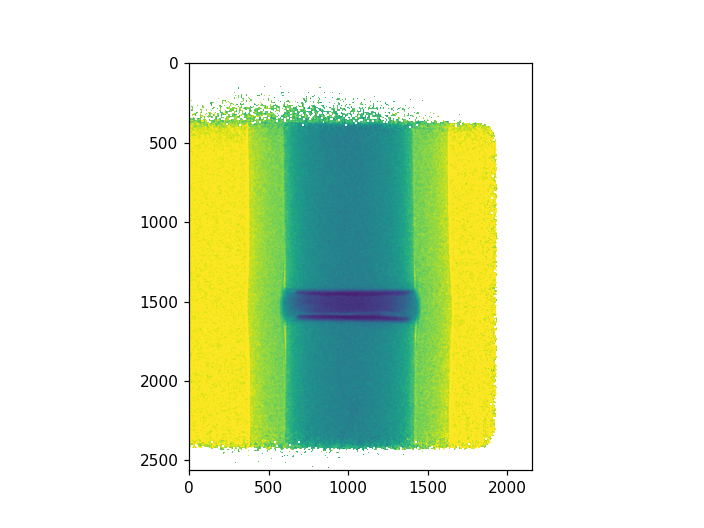

interactive(children=(IntSlider(value=0, description='image_index', layout=Layout(width='50%'), max=5), Output…

In [3]:
o_ipts.visualize_raw_images()

# crop sample to region of interest 

By playing with the **left**, **right**, **top** and **bottom** sliders, select a region surrounding the data you
want to correct.
<html>
    <br>
    <font color="red">Warning:</color>
    </html>
Make sure you include the external cylinder (container) in the selection.

<IPython.core.display.Javascript object>


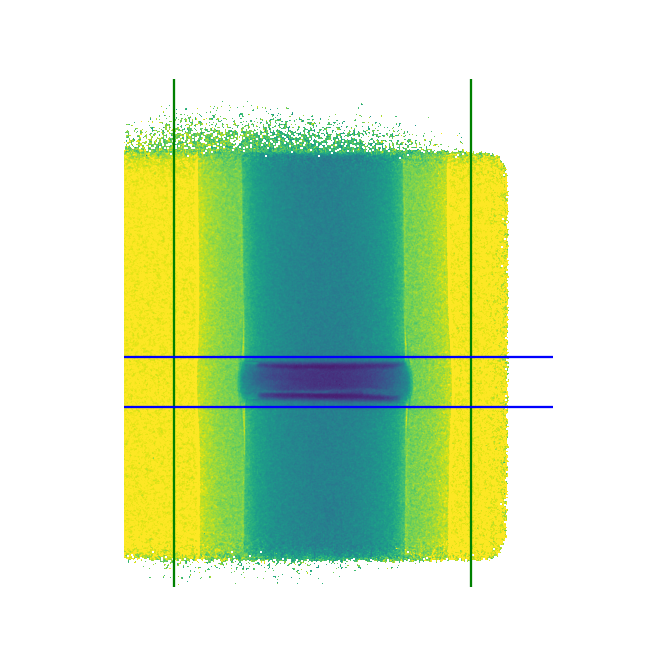

interactive(children=(IntSlider(value=0, description='image_index', max=5), IntSlider(value=251, description='…

In [4]:
o_ipts.select_crop_region()

## Visualize result of cropping 

<IPython.core.display.Javascript object>


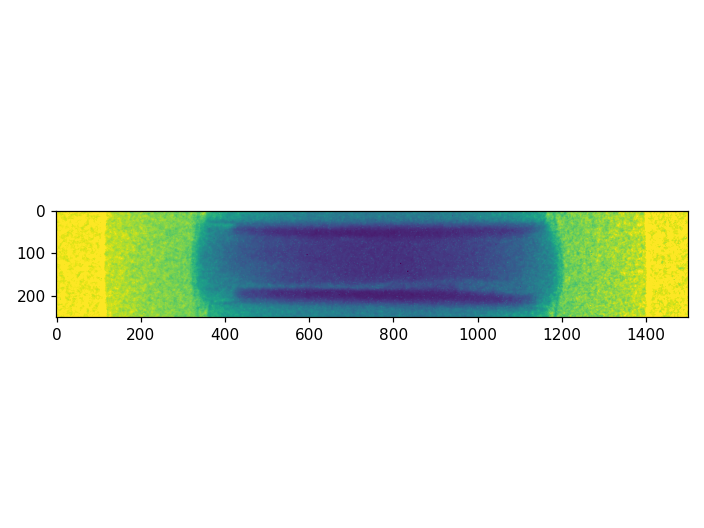

interactive(children=(IntSlider(value=0, description='image_index', max=5), Output()), _dom_classes=('widget-i…

In [5]:
o_ipts.visualize_crop()

# Selection of the profiles to correct

Select the **top limit** and **bottom limit** profiles to correct. The program will integrate vertically all the counts between those two limits.

<IPython.core.display.Javascript object>


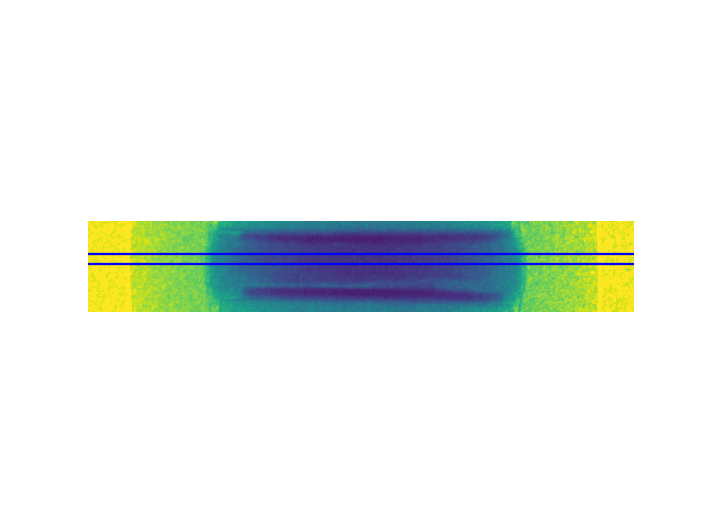

interactive(children=(IntSlider(value=0, description='image_index', max=5), IntSlider(value=89, description='t…

In [6]:
o_ipts.selection_of_profiles_limit()

# Profiles to work with 

<IPython.core.display.Javascript object>


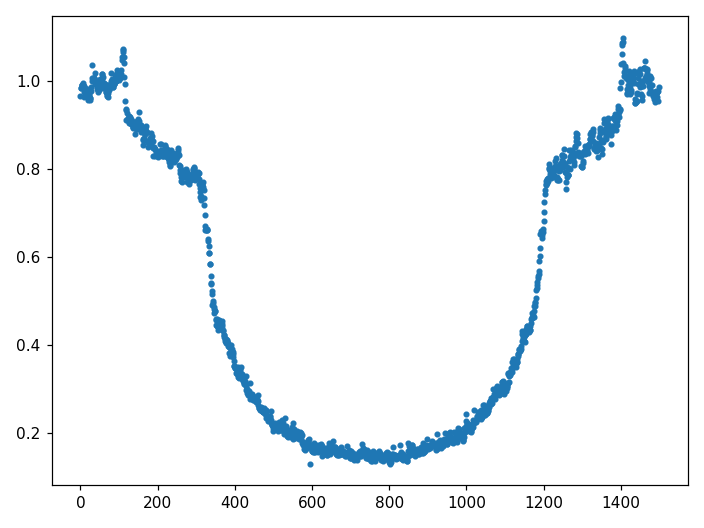

interactive(children=(IntSlider(value=0, description='image_index', max=5), Output()), _dom_classes=('widget-i…

In [7]:
o_ipts.display_of_profiles()

# Let's define the position of the cylinders edges 

<IPython.core.display.Javascript object>


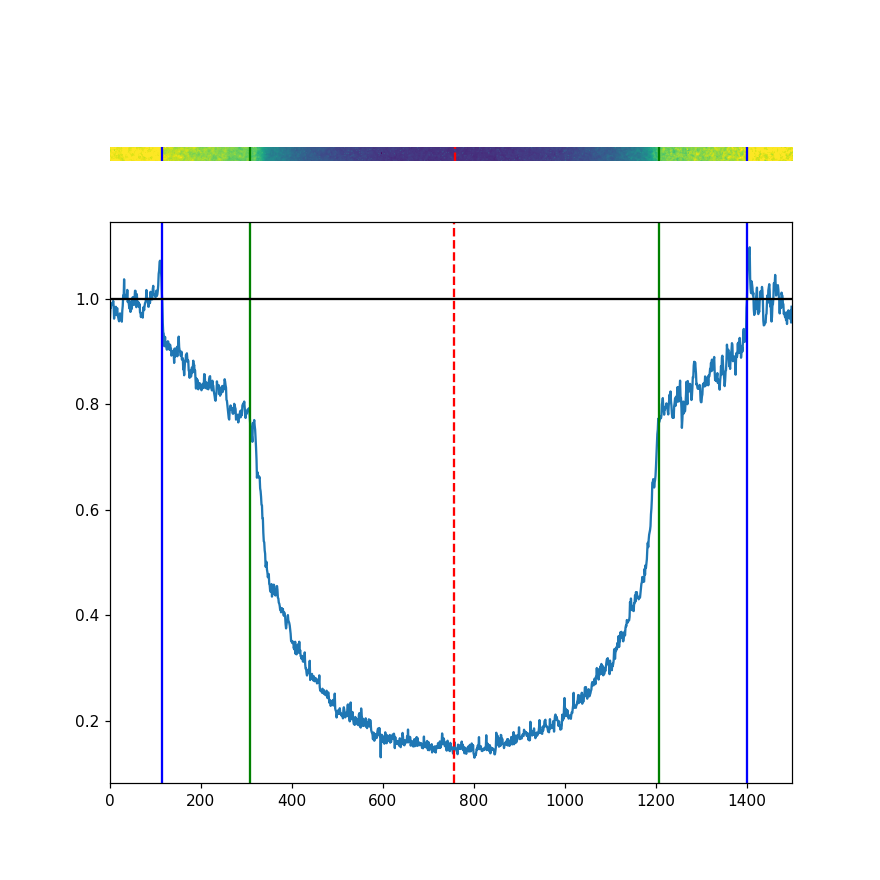

interactive(children=(IntSlider(value=0, description='image_index', max=5), IntSlider(value=757, description='…

In [9]:
o_ipts.cylinders_positions()

# Cleaning edges

Data outside of the cylinders must be removed. To do so, the algorithm will use the **outer_radius** value you defined in the previous cell and will only keep the data within that region.

<IPython.core.display.Javascript object>


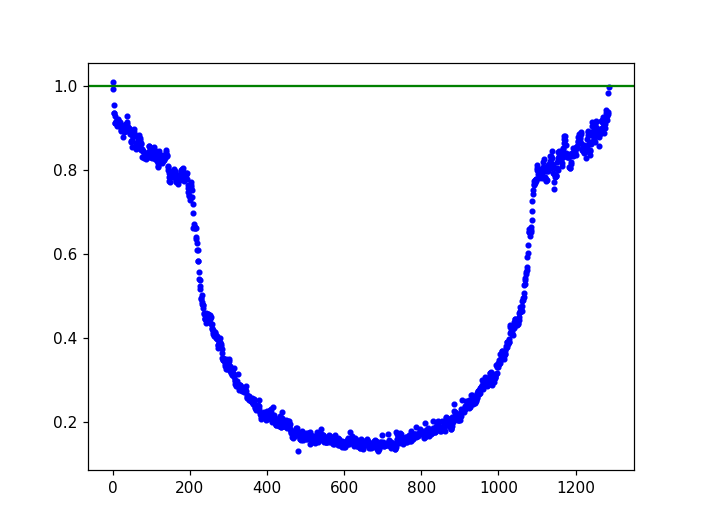

interactive(children=(IntSlider(value=0, description='image_index', max=5), Output()), _dom_classes=('widget-i…

In [10]:
o_ipts.cleaning_edges()

# Switching to attenuation mode  

<IPython.core.display.Javascript object>


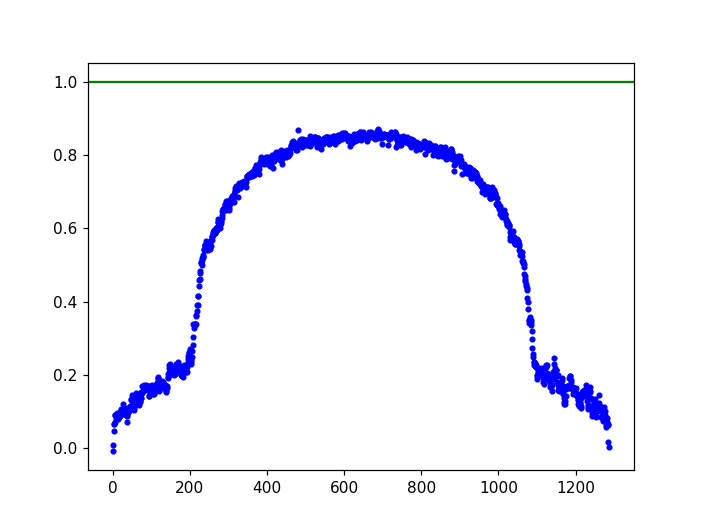

interactive(children=(IntSlider(value=0, description='image_index', max=5), Output()), _dom_classes=('widget-i…

In [11]:
o_ipts.switching_to_attenuation_mode()

# Applying cylindrical geometry correction to the outer cylinder  

Calculate number of counts per pixel in outer cylinder

<IPython.core.display.Javascript object>


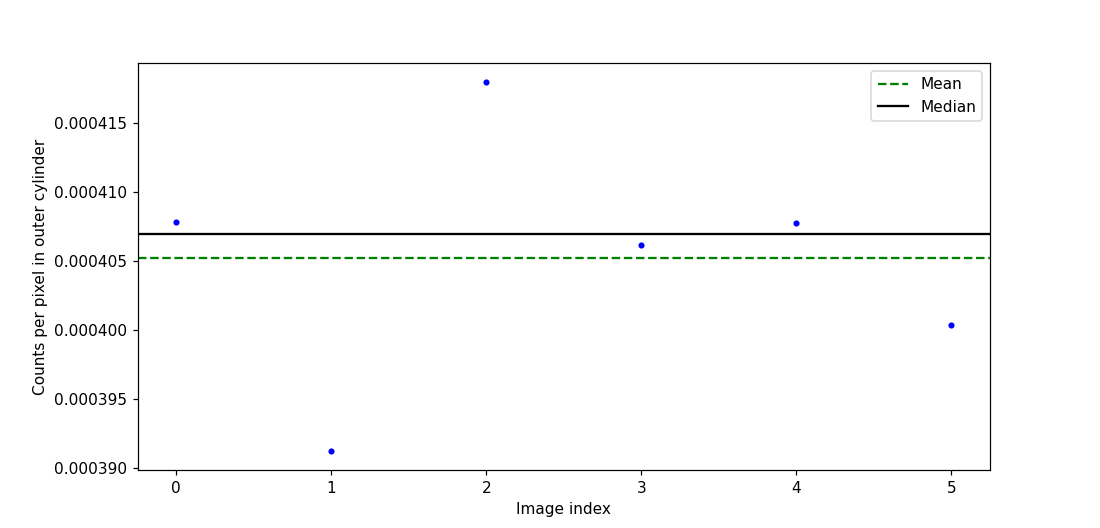

<IPython.core.display.Javascript object>


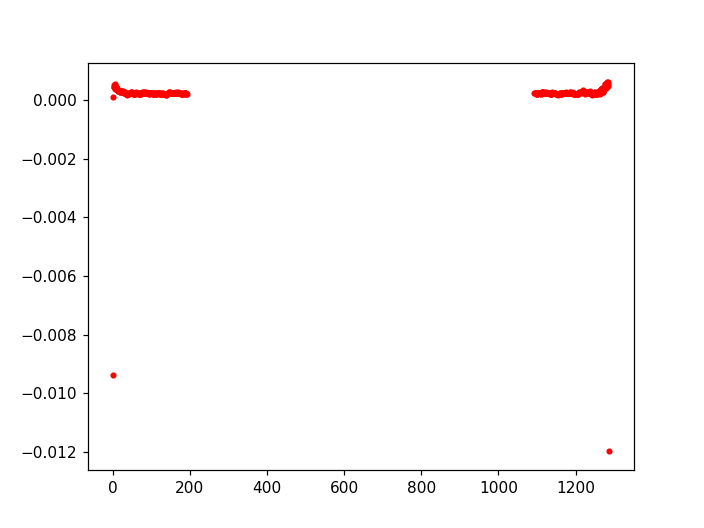

interactive(children=(IntSlider(value=0, description='image_index', max=5), Output()), _dom_classes=('widget-i…

In [12]:
o_ipts.outer_cylinder_geometry_correction(sampling_nbr_of_points=5)

The algorithm will then use the **median** value of the number of counts per pixel in the outer cylinder to finally determine the number of counts per pixel in the inner cylinder.

In [140]:
intensity_of_ring_array = []
for x in np.arange(0, 100):
    measure = profile_data_reversed[x]
    number_of_pixels_through_thickness = number_of_pixels_at_that_position1(position=x, radius=outer_radius)
    intensity_of_ring_array.append(measure / number_of_pixels_through_thickness)
    
intensity_of_ring = np.median(intensity_of_ring_array)

<IPython.core.display.Javascript object>


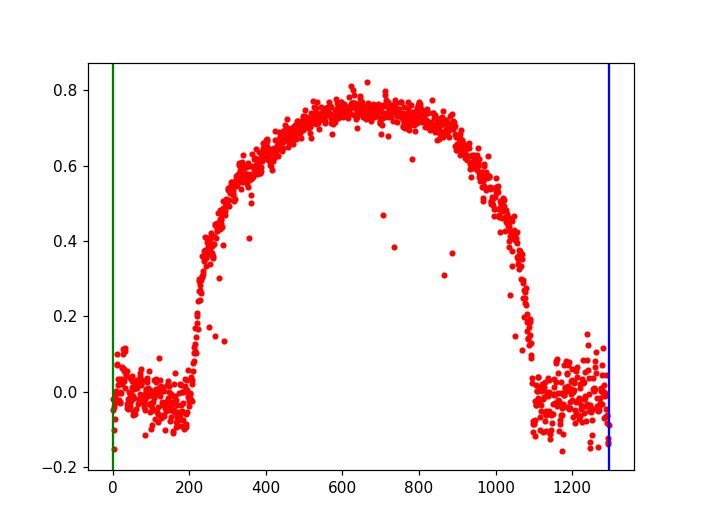

In [141]:
plt.subplots(num='Attenuation per pixel of outer ring')
plt.plot(intensity_of_ring_array, '.b')

In [154]:
shape_of_ring_signal = []
for x in np.arange(0, outer_radius+1):
    nbr_pixels = number_of_pixel_at_that_position2(position=x, 
                                                   inner_circle_r=inner_radius,
                                                   outer_circle_r=outer_radius)

    shape_of_ring_signal.append(nbr_pixels * intensity_of_ring)
    
full_shape_of_ring_signal = np.concatenate((shape_of_ring_signal[::-1], shape_of_ring_signal[:-1:]))

trace = go.Scatter(y=full_shape_of_ring_signal)
layout = go.Layout(title="Shape of ring",
                  xaxis=dict(title=""),
                  yaxis=dict(title=""))

figure = go.Figure(data=[trace], layout=layout)
iplot(figure)

In [167]:
removed_ring_counts = profile_data_reversed - full_shape_of_ring_signal

trace = go.Scatter(y=removed_ring_counts,
                  mode='markers',
                  marker=dict(color='Blue',
                             line=dict(color='Red',
                                      width=1)))
layout = go.Layout(title="shape of ring with outside cylinder corrected",
                   xaxis=dict(title=""),
                   yaxis=dict(title=""))

figure = go.Figure(data=[trace], layout=layout)
iplot(figure)

# Inner cylinder 

We find the center, radius and truncate outside cylinder, keeping only the data from the inner cylinder

In [171]:
center = int(len(removed_ring_counts)/2)
radius = inner_radius

print(f"Center position: {center}")
print(f"radius: {radius}")

Center position: 648
radius: 450


<IPython.core.display.Javascript object>


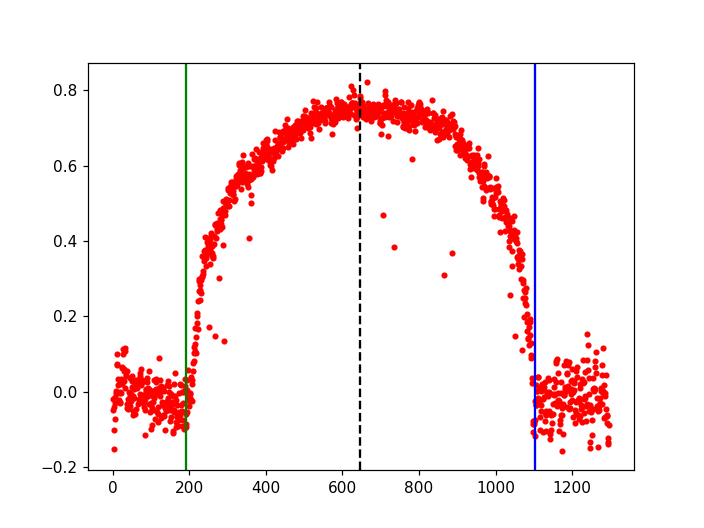

interactive(children=(IntSlider(value=0, description='left_edge', max=1296), IntSlider(value=1296, description…

In [188]:
fig = plt.figure(15)

def find_edges(left_edge, right_edge):  
    ax = plt.subplot()

    plt.cla()
    plt.plot(removed_ring_counts, '.r')
    plt.axvline(x=left_edge, color='green')
    plt.axvline(x=right_edge, color='blue')

    #center
    center = int(np.mean([right_edge, left_edge]))
    plt.axvline(x=center, color='black', linestyle='--')
                 
    
    return left_edge, right_edge

find_edges_ui = interactive(find_edges, 
                    left_edge = widgets.IntSlider(min=0, 
                                                  max=len(removed_ring_counts)-1,
                                                  value=0,
                                                  step=1),
                   right_edge = widgets.IntSlider(min=0, 
                                                  max=len(removed_ring_counts)-1,
                                                  value=len(removed_ring_counts)-1,
                                                  step=1))

display(find_edges_ui)

In [193]:
[left_edge, right_edge] = find_edges_ui.result

print(f"left edge: {left_edge}")
print(f"right edge: {right_edge}")

left edge: 192
right edge: 1102


In [197]:
inner_cylinder_data = removed_ring_counts[left_edge: right_edge+1]
radius = int(len(inner_cylinder_data) / 2)

<IPython.core.display.Javascript object>


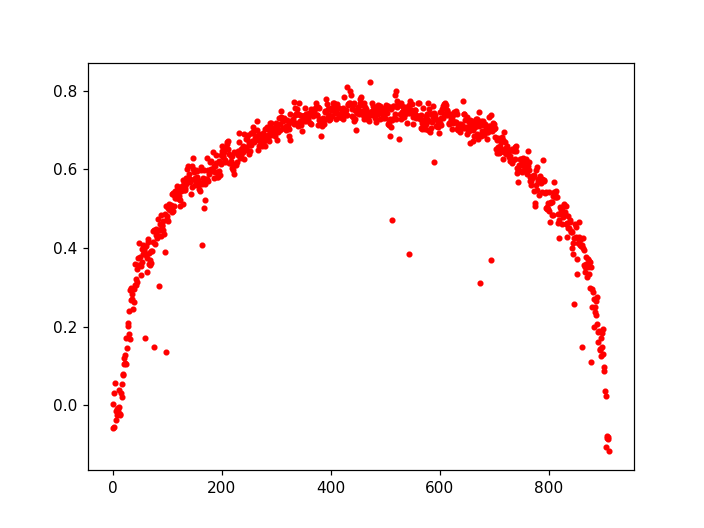

In [196]:
fig = plt.figure(16)
ax = plt.subplot()
plt.plot(inner_cylinder_data, '.r')


In [208]:
d = np.arange(0, 2*radius)
intensity = inner_cylinder_data

expected_array = []
number_of_pixels = []
for _index, x in enumerate(d):
    measure = intensity[_index]
    number_of_pixels_through_thickness = number_of_pixels_at_that_position1(position=x, 
                                                                            radius=radius)
    number_of_pixels.append(number_of_pixels_through_thickness)
    expected_array.append(measure / number_of_pixels_through_thickness)

trace = go.Scatter(y=expected_array, mode='markers')
layout = go.Layout(title="Expected Array",
                  xaxis=dict(title="pixel"),
                  yaxis=dict(title="Counts per pixel",
                             range=[0,.0015],
                            ))

figure = go.Figure(data=[trace], layout=layout)
iplot(figure)